# Noise Model 

Some sections in this notebook are adapted from [Qiskit tutorial](https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/aer/aer_provider.ipynb).

## Introduction

This notebook shows how to use the Qiskit Aer `noise.device` module to automatically generate a noise model for an IBMQ hardware device, and use this model to do noisy simulation of `QuantumCircuits` to study the effects of errors which occur on real devices.


## Circuit

Here we construct a circuit generating 3-qubit GHZ-state: $\frac{1}{\sqrt 2}(\left|000\right\rangle+\left|111\right\rangle)$



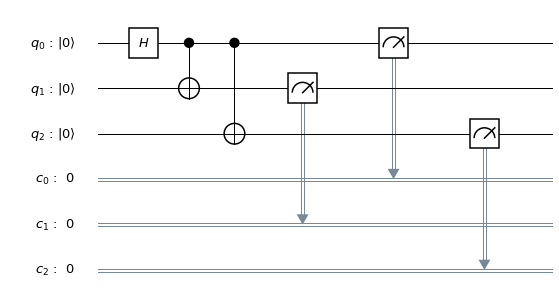

In [13]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram

qr = QuantumRegister(3,'q')
cr = ClassicalRegister(3,'c')
qc = QuantumCircuit(qr, cr)

qc.h(qr[0])
qc.cx(qr[0], qr[1])
qc.cx(qr[0], qr[2])

qc.measure(qr, cr)

%matplotlib inline
qc.draw(output='mpl')

## Noise Model 

Noise models in Qiskit Aer are presented using the `NoiseModel` object . The function we will use is the `basic_device_noise_model` function from `aer.noise.device` module which returns a simplified `NoiseModel` object configured from  `BackendProperties` of a real device.

In [14]:
from qiskit import IBMQ

API_token = ''  #### YOUR API-TOKEN

try:
    IBMQ.enable_account(API_token)
except: True

provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_16_melbourne')

properties = backend.properties()

### Basic device noise model

The `basic_device_noise_model` constructs an approximate noise model consisting of:

* **Single-qubit gate errors** consisting of a <font color="red"> single qubit depolarizing error</font> followed by a <font color="red">single qubit thermal relaxation error</font>.

* **Two-qubit gate errors** consisting of a <font color="red"> two-qubit depolarizing error</font> followed by <font color="red"> single-qubit thermal relaxation errors</font> on both qubits in the gate.

* **Single-qubit readout errors** on the classical bit value obtained from measurements on individual qubits


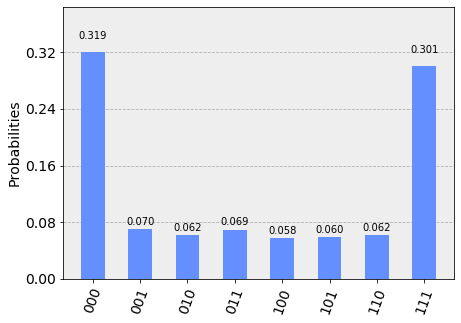

In [15]:
from qiskit.providers.aer import noise

noise_model \
= noise.device.basic_device_noise_model(properties, 
                                        thermal_relaxation=True,
                                        readout_error=True,
                                        gate_error=True)

simulator = Aer.get_backend('qasm_simulator')

job_noise = execute(qc, simulator, 
                    noise_model=noise_model,
                    coupling_map=backend.configuration().coupling_map,
                    basis_gates=noise_model.basis_gates)

result_noise = job_noise.result()
counts_noise = result_noise.get_counts(qc)
plot_histogram(counts_noise)

### Execute on Real Device (melbourne)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Fatal read error on socket transport
protocol: <asyncio.sslproto.SSLProtocol object at 0x1a20289358>
transport: <_SelectorSocketTransport fd=83 read=polling write=<idle, bufsize=0>>
Traceback (most recent call last):
  File "/Users/tsaicheng/anaconda3/lib/python3.7/asyncio/selector_events.py", line 801, in _read_ready__data_received
    data = self._sock.recv(self.max_size)
OSError: [Errno 65] No route to host
Error checking job status using websocket, retrying using HTTP.


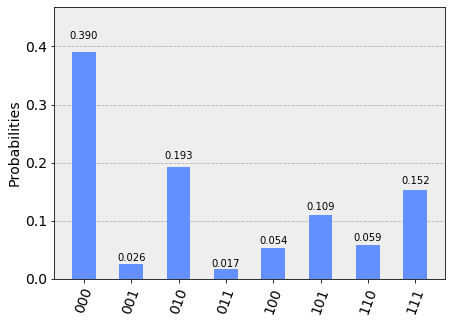

In [22]:
from qiskit.tools.monitor import job_monitor

job = execute(qc, backend)

job_monitor(job, monitor_async=True)

result = job.result()
counts = result.get_counts(qc)
plot_histogram(counts)

You might notice that the counts returned in the above histogram don't look exactly like our simulation. This is because the real errors that happen on a device can be very complicate. The basic device noise model we used for our simulation is a simplified error model that only takes into account local errors occurring on the qubits participating in each individual gate, and treats the errors as a relaxation process combined with an error operation which acts to randomize the state of the qubit with some probability $p$ (the depolarizing probability).

### Real Device (poughkeepsie)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

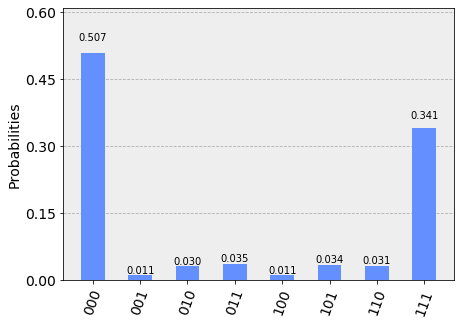

In [24]:
new_backend = IBMQ.get_backend('ibmq_poughkeepsie')

new_job = execute(qc, new_backend)

job_monitor(new_job, monitor_async=True)

new_result = new_job.result()
new_counts = new_result.get_counts(qc)
plot_histogram(new_counts)

### More about noise

`noise.device.basic_device_noise_model(
    properties,
    gate_error=True,
    readout_error=True,
    thermal_relaxation=True,
    temperature=0,
    gate_times=None, ## customized T1, T2 
    standard_gates=True,
)`

#### What is `properties`?

In [34]:
properties = backend.properties()
type(properties)

qiskit.providers.models.backendproperties.BackendProperties

In [35]:
([attr for attr in dir(properties) if attr[0]!='_'])

['as_dict',
 'backend_name',
 'backend_version',
 'from_dict',
 'gates',
 'general',
 'last_update_date',
 'qubits',
 'schema',
 'shallow_schema',
 'to_dict']

In [50]:
print('Gates:\n ', properties.gates[0])
print('\nQubits:')
for i in properties.qubits[0]: print(i)

Gates:
  Gate(gate='u1', parameters=[Nduv(date=datetime.datetime(2019, 8, 6, 6, 25, 15, tzinfo=tzutc()), name='gate_error', unit='', value=0.0)], qubits=[0])

Qubits:
 Nduv(date=datetime.datetime(2019, 8, 6, 6, 20, 11, tzinfo=tzutc()), name='T1', unit='µs', value=53.975460413324335)
Nduv(date=datetime.datetime(2019, 8, 6, 6, 21, 25, tzinfo=tzutc()), name='T2', unit='µs', value=20.120532946759358)
Nduv(date=datetime.datetime(2019, 8, 6, 8, 17, 10, tzinfo=tzutc()), name='frequency', unit='GHz', value=5.100097565060497)
Nduv(date=datetime.datetime(2019, 8, 6, 6, 19, 46, tzinfo=tzutc()), name='readout_error', unit='', value=0.05489999999999995)


#### What is `coupling_map` ?

The class `backendConfiguration` contains information about the backend, including contains number of qubits, basis gate, qubit coupling map, etc.

`coupling_map` is an instance of `backendConfiguration`. It describes all qubits pairs that we can apply two-qubit gate on it.

In [54]:
config = backend.configuration()
coupling_map = config.coupling_map
coupling_map

[[1, 0],
 [1, 2],
 [2, 3],
 [4, 3],
 [4, 10],
 [5, 4],
 [5, 6],
 [5, 9],
 [6, 8],
 [7, 8],
 [9, 8],
 [9, 10],
 [11, 3],
 [11, 10],
 [11, 12],
 [12, 2],
 [13, 1],
 [13, 12]]

In [55]:
from qiskit.tools.jupyter import *
%qiskit_backend_monitor backend

Since `basic_device_noise_model` requires backend properties and coupling map to generate noise model, we may design a virtual noisy backend for noise simulation by mimicking backend properties and coupling map, e.g. a fully-connected noisy backend, which is not realizable on any real device. 

Note: You can also build your own noise models. See [this tutorial on Github](https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/aer/building_noise_models.ipynb).